In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import seaborn as sns

In [4]:
train = pd.read_csv("data/RT_IOT2022.csv")
print(train.info())
print(train.describe())
train.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123117 entries, 0 to 123116
Data columns (total 85 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0                123117 non-null  int64  
 1   id.orig_p                 123117 non-null  int64  
 2   id.resp_p                 123117 non-null  int64  
 3   proto                     123117 non-null  object 
 4   service                   123117 non-null  object 
 5   flow_duration             123117 non-null  float64
 6   fwd_pkts_tot              123117 non-null  int64  
 7   bwd_pkts_tot              123117 non-null  int64  
 8   fwd_data_pkts_tot         123117 non-null  int64  
 9   bwd_data_pkts_tot         123117 non-null  int64  
 10  fwd_pkts_per_sec          123117 non-null  float64
 11  bwd_pkts_per_sec          123117 non-null  float64
 12  flow_pkts_per_sec         123117 non-null  float64
 13  down_up_ratio             123117 non-null  f

Unnamed: 0  id.orig_p  id.resp_p proto service  flow_duration  \
123112        2005      59247      63331   tcp       -       0.000006   
123113        2006      59247      64623   tcp       -       0.000007   
123114        2007      59247      64680   tcp       -       0.000006   
123115        2008      59247      65000   tcp       -       0.000006   
123116        2009      59247      65129   tcp       -       0.000006   

        fwd_pkts_tot  bwd_pkts_tot  fwd_data_pkts_tot  bwd_data_pkts_tot  ...  \
123112             1             1                  0                  0  ...   
123113             1             1                  0                  0  ...   
123114             1             1                  0                  0  ...   
123115             1             1                  0                  0  ...   
123116             1             1                  0                  0  ...   

        active.std  idle.min  idle.max  idle.tot  idle.avg  idle.std  \
123112         0.0       0.0       0.0       0.0       0.0       0.0   
123113         0.0       0.0       0.0       0.0       0.0       0.0   
123114         0.0       0.0       0.0       0.0       0.0       0.0   
123115         0.0       0.0       0.0       0.0       0.0       0.0   
123116         0.0       0.0       0.0       0.0       0.0       0.0   

        fwd_init_window_size  bwd_init_window_size  fwd_last_window_size  \
123112                  1024                     0                  1024   
123113                  1024                     0                  1024   
123114                  1024                     0                  1024   
123115                  1024                     0                  1024   
123116                  1024                     0                  1024   

                Attack_type  
123112  NMAP_XMAS_TREE_SCAN  
123113  NMAP_XMAS_TREE_SCAN  
123114  NMAP_XMAS_TREE_SCAN  
123115  NMAP_XMAS_TREE_SCAN  
123116  NMAP_XMAS_TREE_SCAN  

[5 rows x 85 columns]

In [5]:
train.duplicated().any()


np.False_

---
##### To-do
- heatmap
- class balancing (77% is DoS) - SMOTE?
- feature importance -> random forest feature importance, PCA, MI score, etc.


##### Done
- make a binary benign/malicious feature - benign - MQTT, Thing_speak, Wipro
- figure out what weird col is
- Show distributions - target distribustions, categorical box plot and histogram
- convert categorical
- normalization - standardScaler, min-max


---

## Histograms

**Target**: benign -> 'MQTT_Publish, 'Thing_speak', and 'Wipro_bulb'

In [6]:
train["Attack_type"].unique()

array(['MQTT_Publish', 'Thing_Speak', 'Wipro_bulb', 'ARP_poisioning',
       'DDOS_Slowloris', 'DOS_SYN_Hping', 'Metasploit_Brute_Force_SSH',
       'NMAP_FIN_SCAN', 'NMAP_OS_DETECTION', 'NMAP_TCP_scan',
       'NMAP_UDP_SCAN', 'NMAP_XMAS_TREE_SCAN'], dtype=object)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'MQTT_Publish'),
  Text(1, 0, 'Thing_Speak'),
  Text(2, 0, 'Wipro_bulb'),
  Text(3, 0, 'ARP_poisioning'),
  Text(4, 0, 'DDOS_Slowloris'),
  Text(5, 0, 'DOS_SYN_Hping'),
  Text(6, 0, 'Metasploit_Brute_Force_SSH'),
  Text(7, 0, 'NMAP_FIN_SCAN'),
  Text(8, 0, 'NMAP_OS_DETECTION'),
  Text(9, 0, 'NMAP_TCP_scan'),
  Text(10, 0, 'NMAP_UDP_SCAN'),
  Text(11, 0, 'NMAP_XMAS_TREE_SCAN')])

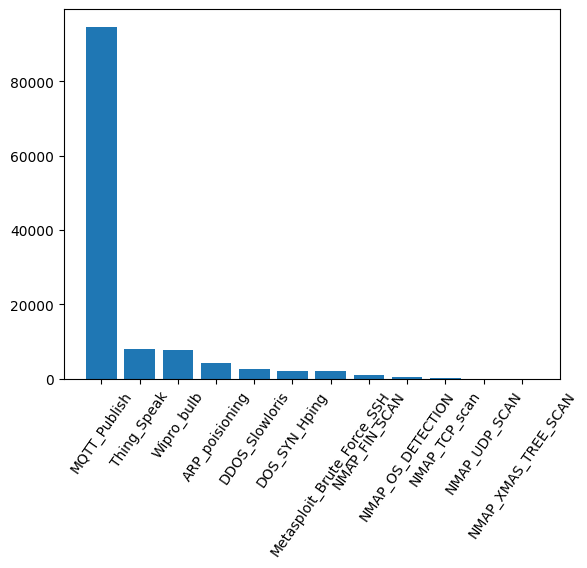

In [7]:
target = train.pop('Attack_type')
plt.bar(target.unique(), target.value_counts())
plt.xticks(rotation=55)

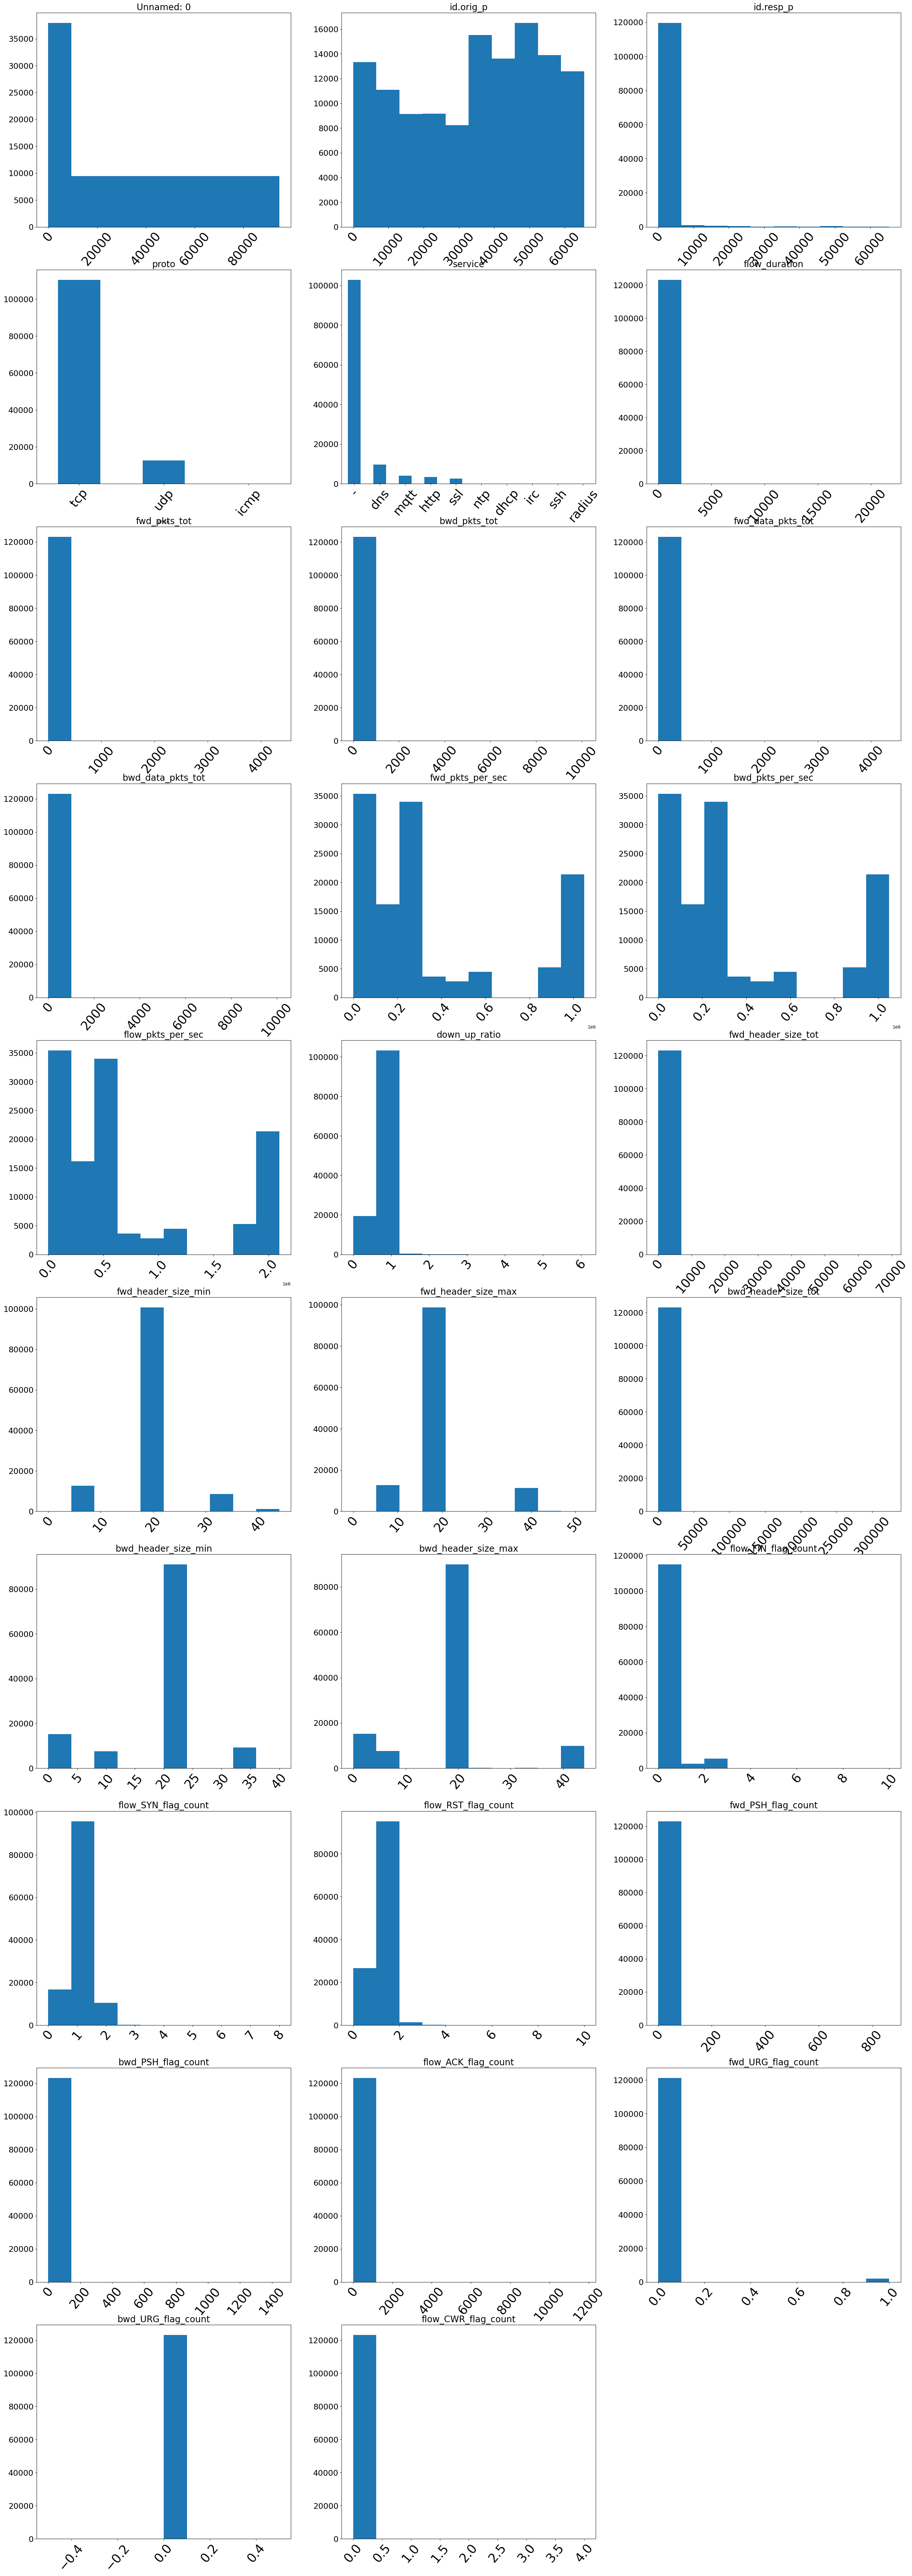

In [8]:
def visualizeHistograms(data):
    plt.figure(figsize=(35 ,230))
    for i in range(29):
        plt.subplot(11, 3, i + 1) 
        plt.subplots_adjust(bottom=.5) 
        plt.title(f"{data.columns[i]}",fontsize=20)
        if not pd.api.types.is_numeric_dtype(data.iloc[:, i]):
            data[data.columns[i]].value_counts().plot(kind='bar')
        else:
            plt.hist(train.iloc[:, i])
        
        plt.xticks(fontsize=28,rotation=50)
        plt.yticks(fontsize=18)
        # plt.yscale('log') # for scaling down of outliers, i.e. makes them more visible to the eye in the graphs
    plt.show()

visualizeHistograms(train)

## Drop Columns
'Unnamed: 0' is an useless column that's kinda like an index but not since each entry is not distinct

In [9]:
train = train.drop("Unnamed: 0", axis=1)
train.shape

(123117, 83)

## Encoding

- Ordinal encoding for the service column. *note*: might switch to oneHot for this one too idk
- One hot encoding for protocol column since only 3 distinct protocols

In [10]:
train['service'] = sklearn.preprocessing.OrdinalEncoder().fit_transform(train[['service']]).astype(int)
train['service']

0         5
1         5
2         5
3         5
4         5
         ..
123112    0
123113    0
123114    0
123115    0
123116    0
Name: service, Length: 123117, dtype: int64

In [11]:
train = pd.get_dummies(train)
train.shape

(123117, 85)

## Normalization

*Note:* Even though this is only necessary for the **Non-tree** based models (i.e. not xgboost or random forest), for consistency, all models will used the scaled data. There is no significant difference on the tree models when using scaled vs. raw data.

Used minmax scaler since all data is positive and we have outliers

In [12]:
trainScaled = pd.DataFrame(sklearn.preprocessing.MinMaxScaler().fit_transform(train), columns=train.columns, index=train.index)
trainScaled

id.orig_p  id.resp_p   service  flow_duration  fwd_pkts_tot  \
0        0.590021   0.028797  0.555556   1.473265e-03      0.002071   
1        0.780392   0.028797  0.555556   1.467374e-03      0.002071   
2        0.683009   0.028797  0.555556   1.478441e-03      0.002071   
3        0.929168   0.028797  0.555556   1.470939e-03      0.002071   
4        0.779538   0.028797  0.555556   1.468238e-03      0.002071   
...           ...        ...       ...            ...           ...   
123112   0.904051   0.968527  0.000000   2.761371e-10      0.000230   
123113   0.904051   0.988285  0.000000   3.221600e-10      0.000230   
123114   0.904051   0.989157  0.000000   2.761371e-10      0.000230   
123115   0.904051   0.994051  0.000000   2.761371e-10      0.000230   
123116   0.904051   0.996024  0.000000   2.761371e-10      0.000230   

        bwd_pkts_tot  fwd_data_pkts_tot  bwd_data_pkts_tot  fwd_pkts_per_sec  \
0           0.000494            0.00069           0.000297      2.681236e-07   
1           0.000494            0.00069           0.000297      2.692003e-07   
2           0.000494            0.00069           0.000297      2.671852e-07   
3           0.000494            0.00069           0.000297      2.685480e-07   
4           0.000494            0.00069           0.000297      2.690420e-07   
...              ...                ...                ...               ...   
123112      0.000099            0.00000           0.000000      1.600000e-01   
123113      0.000099            0.00000           0.000000      1.379310e-01   
123114      0.000099            0.00000           0.000000      1.600000e-01   
123115      0.000099            0.00000           0.000000      1.600000e-01   
123116      0.000099            0.00000           0.000000      1.600000e-01   

        bwd_pkts_per_sec  ...  idle.max  idle.tot  idle.avg  idle.std  \
0           1.489573e-07  ...  0.099097  0.001418  0.099097       0.0   
1           1.495562e-07  ...  0.099518  0.001424  0.099518       0.0   
2           1.484365e-07  ...  0.099474  0.001423  0.099474       0.0   
3           1.491928e-07  ...  0.099713  0.001427  0.099713       0.0   
4           1.494675e-07  ...  0.099382  0.001422  0.099382       0.0   
...                  ...  ...       ...       ...       ...       ...   
123112      1.600000e-01  ...  0.000000  0.000000  0.000000       0.0   
123113      1.379310e-01  ...  0.000000  0.000000  0.000000       0.0   
123114      1.600000e-01  ...  0.000000  0.000000  0.000000       0.0   
123115      1.600000e-01  ...  0.000000  0.000000  0.000000       0.0   
123116      1.600000e-01  ...  0.000000  0.000000  0.000000       0.0   

        fwd_init_window_size  bwd_init_window_size  fwd_last_window_size  \
0                   0.980240              0.409659              0.007660   
1                   0.980240              0.409659              0.007660   
2                   0.980240              0.409659              0.007660   
3                   0.980240              0.409659              0.007660   
4                   0.980240              0.409659              0.007660   
...                      ...                   ...                   ...   
123112              0.015625              0.000000              0.015625   
123113              0.015625              0.000000              0.015625   
123114              0.015625              0.000000              0.015625   
123115              0.015625              0.000000              0.015625   
123116              0.015625              0.000000              0.015625   

        proto_icmp  proto_tcp  proto_udp  
0              0.0        1.0        0.0  
1              0.0        1.0        0.0  
2              0.0        1.0        0.0  
3              0.0        1.0        0.0  
4              0.0        1.0        0.0  
...            ...        ...        ...  
123112         0.0        1.0        0.0  
123113         0.0        1.0        0.0  
123114         0.

## Feature Engineering

- **binary_target** - if target is benign traffic then 0 else if malicious 1
- **bianry_oneHot** - One Hot encoded target. Therefore, there's 9 new binary columns; one for each class.

In [13]:
benign = ['MQTT_Publish', 'Thing_speak', 'Wipro_bulb']
binary_target = pd.DataFrame([0 if x in benign else 1 for x in target])

In [14]:
target_oneHot = pd.get_dummies(target, dtype=int)
print(target_oneHot.shape)
target_oneHot

(123117, 12)


ARP_poisioning  DDOS_Slowloris  DOS_SYN_Hping  MQTT_Publish  \
0                    0               0              0             1   
1                    0               0              0             1   
2                    0               0              0             1   
3                    0               0              0             1   
4                    0               0              0             1   
...                ...             ...            ...           ...   
123112               0               0              0             0   
123113               0               0              0             0   
123114               0               0              0             0   
123115               0               0              0             0   
123116               0               0              0             0   

        Metasploit_Brute_Force_SSH  NMAP_FIN_SCAN  NMAP_OS_DETECTION  \
0                                0              0                  0   
1                                0              0                  0   
2                                0              0                  0   
3                                0              0                  0   
4                                0              0                  0   
...                            ...            ...                ...   
123112                           0              0                  0   
123113                           0              0                  0   
123114                           0              0                  0   
123115                           0              0                  0   
123116                           0              0                  0   

        NMAP_TCP_scan  NMAP_UDP_SCAN  NMAP_XMAS_TREE_SCAN  Thing_Speak  \
0                   0              0                    0            0   
1                   0              0                    0            0   
2                   0              0                    0            0   
3                   0              0                    0            0   
4                   0              0                    0            0   
...               ...            ...                  ...          ...   
123112              0              0                    1            0   
123113              0              0                    1            0   
123114              0              0                    1            0   
123115              0              0                    1            0   
123116              0              0                    1            0   

        Wipro_bulb  
0                0  
1                0  
2                0  
3                0  
4                0  
...            ...  
123112           0  
123113           0  
123114           0  
123115           0  
123116           0  

[123117 rows x 12 columns]

## Heatmap

- heatmap is way to big rn, either split into sections or do some feature importance to eliminate some columns first

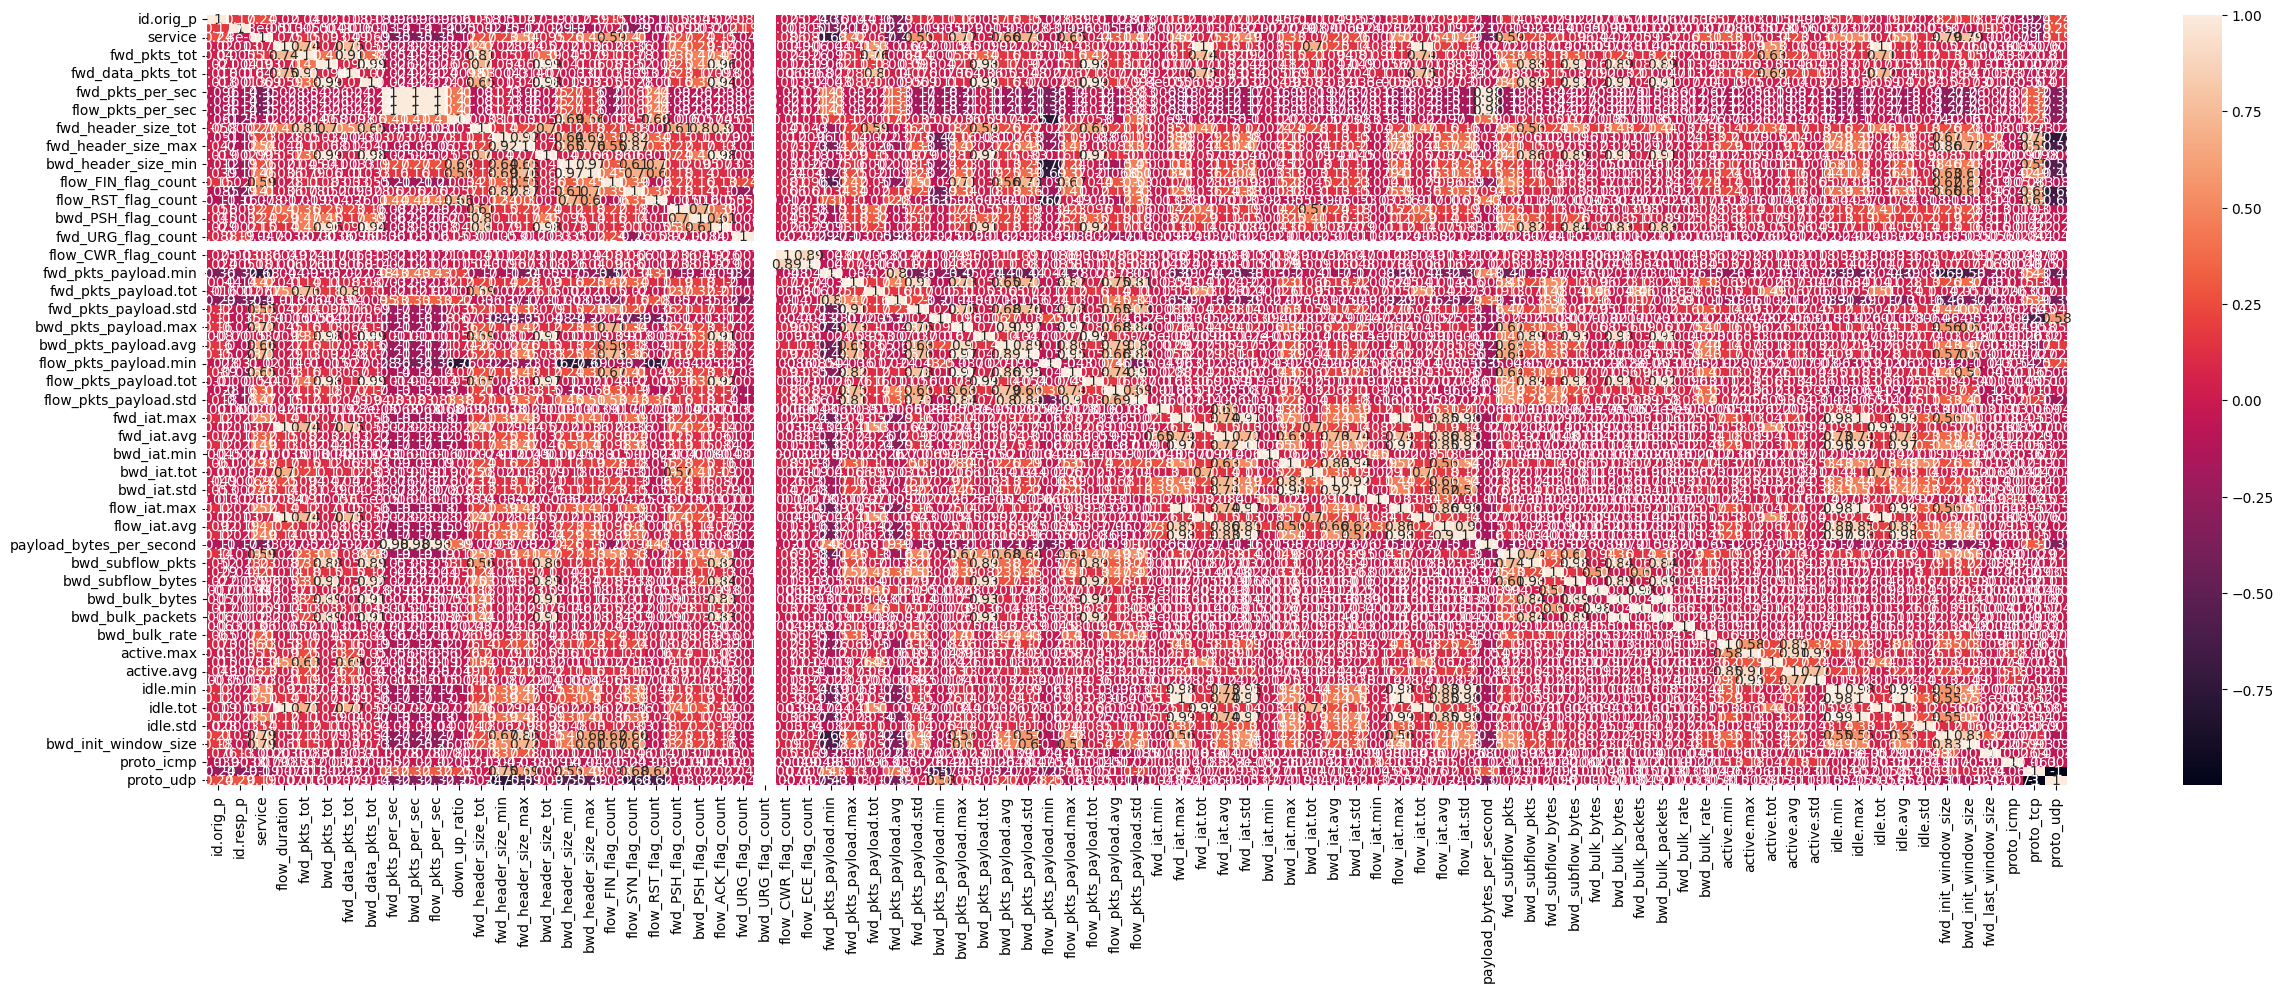

In [15]:
plt.figure(figsize=(30, 10))
sns.heatmap(train.corr(), annot=True)
plt.show()

---

### Papers to look into

- A Novel Hybrid Architecture for Superior IoT Threat Detection through Real IoT Environments - https://www.sciencedirect.com/org/science/article/pii/S1546221824007963#ref-31 
Uses dnn models like in paper 2. Uses Rt-IoT2022 dataset. Interestingly, converted this dataset back into time series data. They applied stratified sampling whcih involves dividing the data into strata based on threat types and then sampling proportionally from each stratum; useful for properly distributed train-test sets. They stacked a bunch of different NNs to leverage each of their benefits...basically made an ensemble nn model. Compared this model against commonly used ones, mainly ensemble ML. Couldn't find much on resource consumption fo this tho....seems quite costly.

- TFKAN: Transformer based on Kolmogorov–Arnold Networks for Intrusion Detection in IoT environment - https://www.sciencedirect.com/science/article/pii/S1110866525000593?ref=pdf_download&fr=RR-2&rr=985cea4b28ac64b3
Uses nn model but instead of MLP layers they used KAN. Used RT-IoT2022 dataset and 2 others. Should save on parameter number. Good related research section and end section compared against literature models. used min-max scaling.

- Expanding analytical capabilities in intrusion detection through ensemble-based multi-label classification - https://www.sciencedirect.com/science/article/pii/S0167404824000312?via%3Dihub Didn't use RT-IoT2022 dataset. used ensemble methods like in paper 1, but was ensemble nn. Multi-class detection: Interestingly, made one model for each class. Each model focuses on learning the distribution specifically related to its assigned set of labels, independent of the other label sets. Stated computational complexity didn't increase.

- PCIDS: Permission and Credibility-Based Intrusion Detection System in IoT Gateways - https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=10176268  Good related research and model comparision section. Quite different than our (and other papers already gathered) approach.

- Transformer-based knowledge distillation for explainable intrusion detection system - https://www.sciencedirect.com/science/article/pii/S0167404825001063 used rt-iot2022. used min-max scaling. highlights dl resource cost. notes time series data is important. Model: a Transformer-based teacher model, which utilizes a hybrid attention mechanism combining multi-head self-attention (MHSA) and cross-attention layers. makes results interpretable. 